NiN network in network
基本架构，用多个卷积相互连接，每块最后两层是kernel为1的卷积层，代替全连接，模型参数量小，最后再加上一层全局池化

In [2]:
import torch
from d2l.torch import d2l
from torch import nn

In [3]:
# 定义一个nin块
def Nin_block(in_channel,out_channel,kernel_size,stride,padding):
    return nn.Sequential(
        nn.Conv2d(in_channel,out_channel,kernel_size,stride,padding),
        nn.ReLU(),
        nn.Conv2d(out_channel,out_channel,1),
        nn.ReLU(),
        nn.Conv2d(out_channel,out_channel,1),
        nn.ReLU()
    )

In [11]:
# 定义nin模型
net=nn.Sequential(
    Nin_block(1,96,11,4,0),
    nn.MaxPool2d(3,stride=2),
    Nin_block(96,256,5,1,2),
    nn.MaxPool2d(3,stride=2),
    Nin_block(256,384,3,1,1),
    nn.MaxPool2d(3,stride=2),
    nn.Dropout(0.4),
    Nin_block(384,10,3,1,1),
    nn.AdaptiveAvgPool2d((1,1)),  # 全局平均池化，高宽变成1
    nn.Flatten(),
    nn.ReLU()
)

net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [12]:
image=torch.rand((1,1,227,227))
net(image).shape

torch.Size([1, 10])

training on cuda:0


RuntimeError: DataLoader worker (pid(s) 15036, 16092, 6828, 3688) exited unexpectedly

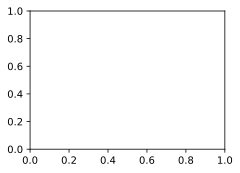

In [14]:
# 训练过程
batch_size = 50
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=227)

def evaluate_accuracy_gpu(net, data_iter, device=None):  # @save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式，对于验证集应该这样设置
        if not device:
            device = next(iter(net.parameters())).device  # net.parameters()获得模型的所有参数，
            # 再放入迭代器中，获取第一个参数所在迭代器
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():  # 关闭自动求导
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


# @save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],  # xlim-x的范围
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)  # 定时器类
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))

        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    animator.show()
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


lr, num_epochs = 0.1, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())